In [1]:
import pandas as pd

DATA = '../Data/Customers_clustered.csv'

df_clusterd = pd.read_csv(DATA)

In [2]:
df_clusterd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

In [3]:
X = df_clusterd.drop('Response', axis=1)
y = df_clusterd['Response']

In [4]:
#OneHotEncolder para colunas categóricas
one_hot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    'cluster'
]

#Standard para colunas com distribuição normal
standard_cols = [
    "Income",
    "Age",
]


#PowerTransform para colunas que parecem potência, tem um decaimento muito acentuado
power_cols = X.columns[
   X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()



minmax_cols = [
    col for col in X.columns if col not in one_hot_cols + standard_cols + power_cols
]

In [5]:
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline  # atenção para o Pipeline do ImbLearn
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42

models = {
    "DummyClassifier": DummyClassifier(
        strategy="stratified", random_state=RANDOM_STATE
    ),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


def pipeline_model(X, y, model, kf):
    preprocessing = ColumnTransformer(
        [
            ("one-hot", OneHotEncoder(), one_hot_cols),
            ("standard", StandardScaler(), standard_cols),
            ("minmax", MinMaxScaler(), minmax_cols),
            ("power", PowerTransformer(), power_cols),
        ]
    )

    pipeline = Pipeline(
        [
            ("preprocessing", preprocessing),
            ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
            ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
            ("model", model),
        ]
    )

    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-1,
    )

    return scores

In [6]:
results = {
    "DummyClassifier": pipeline_model(X, y, models["DummyClassifier"], skf),
    "DecisionTreeClassifier": pipeline_model(X, y, models["DecisionTreeClassifier"], skf),
    "LogisticRegression": pipeline_model(X, y, models["LogisticRegression"], skf),
    "KNNClassifier": pipeline_model(X, y, models["KNNClassifier"], skf),
}

In [7]:
from pprint import pprint

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.17591214, 0.15937614, 0.15712833, 0.17650151, 0.18482399]),
                            'score_time': array([0.12826085, 0.13725519, 0.13368607, 0.10386682, 0.12247896]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.68027211]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.21496452]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.25165563]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.57575758]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.64181818])},
 'DummyClassifier': {'fit_time': array([0.19449067, 0.20208883, 0.17398572, 0.18506789, 0.17253876]),
                     'score_time': array([0.11615562, 0.1204133 , 0.16001987, 0.1342926 , 0.14656234

In [8]:
for k, v in results.items():
    results[k]["time"] = results[k]["fit_time"] + results[k]["score_time"]

pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.17591214, 0.15937614, 0.15712833, 0.17650151, 0.18482399]),
                            'score_time': array([0.12826085, 0.13725519, 0.13368607, 0.10386682, 0.12247896]),
                            'test_accuracy': array([0.82539683, 0.82993197, 0.82993197, 0.81179138, 0.68027211]),
                            'test_average_precision': array([0.3683831 , 0.38016844, 0.3602606 , 0.43117226, 0.21496452]),
                            'test_precision': array([0.43243243, 0.44444444, 0.44871795, 0.40229885, 0.25165563]),
                            'test_recall': array([0.47761194, 0.47761194, 0.52238806, 0.53030303, 0.57575758]),
                            'test_roc_auc': array([0.68534999, 0.70773805, 0.73826722, 0.71830303, 0.64181818]),
                            'time': array([0.30417299, 0.29663134, 0.2908144 , 0.28036833, 0.30730295])},
 'DummyClassifier': {'fit_time': array([0.19449067, 0.20208883, 0.17398572, 0.18506789, 0.1725387

In [9]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})
df_results

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,"[0.19449067115783691, 0.2020888328552246, 0.17...","[0.11615562438964844, 0.12041330337524414, 0.1...","[0.5124716553287982, 0.5034013605442177, 0.503...","[0.1542056074766355, 0.14485981308411214, 0.14...","[0.4925373134328358, 0.4626865671641791, 0.462...","[0.5042900470907494, 0.4866908771649773, 0.486...","[0.15304952129175473, 0.14865734269715697, 0.1...","[0.31064629554748535, 0.32250213623046875, 0.3..."
1,DecisionTreeClassifier,"[0.17591214179992676, 0.1593761444091797, 0.15...","[0.12826085090637207, 0.13725519180297852, 0.1...","[0.8253968253968254, 0.8299319727891157, 0.829...","[0.43243243243243246, 0.4444444444444444, 0.44...","[0.47761194029850745, 0.47761194029850745, 0.5...","[0.6853499880277755, 0.7077380477292681, 0.738...","[0.3683830979533475, 0.38016844076749257, 0.36...","[0.30417299270629883, 0.2966313362121582, 0.29..."
2,LogisticRegression,"[0.1891345977783203, 0.21468019485473633, 0.17...","[0.06369829177856445, 0.05774688720703125, 0.0...","[0.7845804988662132, 0.8299319727891157, 0.829...","[0.35106382978723405, 0.4444444444444444, 0.45...","[0.4925373134328358, 0.47761194029850745, 0.53...","[0.6857091547609545, 0.7083167052438343, 0.738...","[0.3819814120613085, 0.41502673077110863, 0.36...","[0.25283288955688477, 0.2724270820617676, 0.23..."
3,KNNClassifier,"[0.18843579292297363, 0.18363237380981445, 0.1...","[0.12640166282653809, 0.143235445022583, 0.133...","[0.8503401360544217, 0.8526077097505669, 0.854...","[0.5172413793103449, 0.5333333333333333, 0.565...","[0.22388059701492538, 0.23880597014925373, 0.1...","[0.6013049724638838, 0.6030010375927847, 0.606...","[0.2835258077353654, 0.3012183978068839, 0.252...","[0.3148374557495117, 0.32686781883239746, 0.31..."


In [10]:
df_results_explode = df_results.explode(
    df_results.columns[1:].to_list()
).reset_index(drop=True)

df_results_explode

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.194491,0.116156,0.512472,0.154206,0.492537,0.50429,0.15305,0.310646
1,DummyClassifier,0.202089,0.120413,0.503401,0.14486,0.462687,0.486691,0.148657,0.322502
2,DummyClassifier,0.173986,0.16002,0.503401,0.14486,0.462687,0.486691,0.148657,0.334006
3,DummyClassifier,0.185068,0.134293,0.487528,0.126168,0.409091,0.455212,0.14005,0.31936
4,DummyClassifier,0.172539,0.146562,0.510204,0.149533,0.484848,0.499758,0.149598,0.319101
5,DecisionTreeClassifier,0.175912,0.128261,0.825397,0.432432,0.477612,0.68535,0.368383,0.304173
6,DecisionTreeClassifier,0.159376,0.137255,0.829932,0.444444,0.477612,0.707738,0.380168,0.296631
7,DecisionTreeClassifier,0.157128,0.133686,0.829932,0.448718,0.522388,0.738267,0.360261,0.290814
8,DecisionTreeClassifier,0.176502,0.103867,0.811791,0.402299,0.530303,0.718303,0.431172,0.280368
9,DecisionTreeClassifier,0.184824,0.122479,0.680272,0.251656,0.575758,0.641818,0.214965,0.307303


C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_40048\557960148.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_40048\557960148.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_40048\557960148.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\gustavo.martins\AppData\Local\Temp\ipykernel_40048\557960148.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b

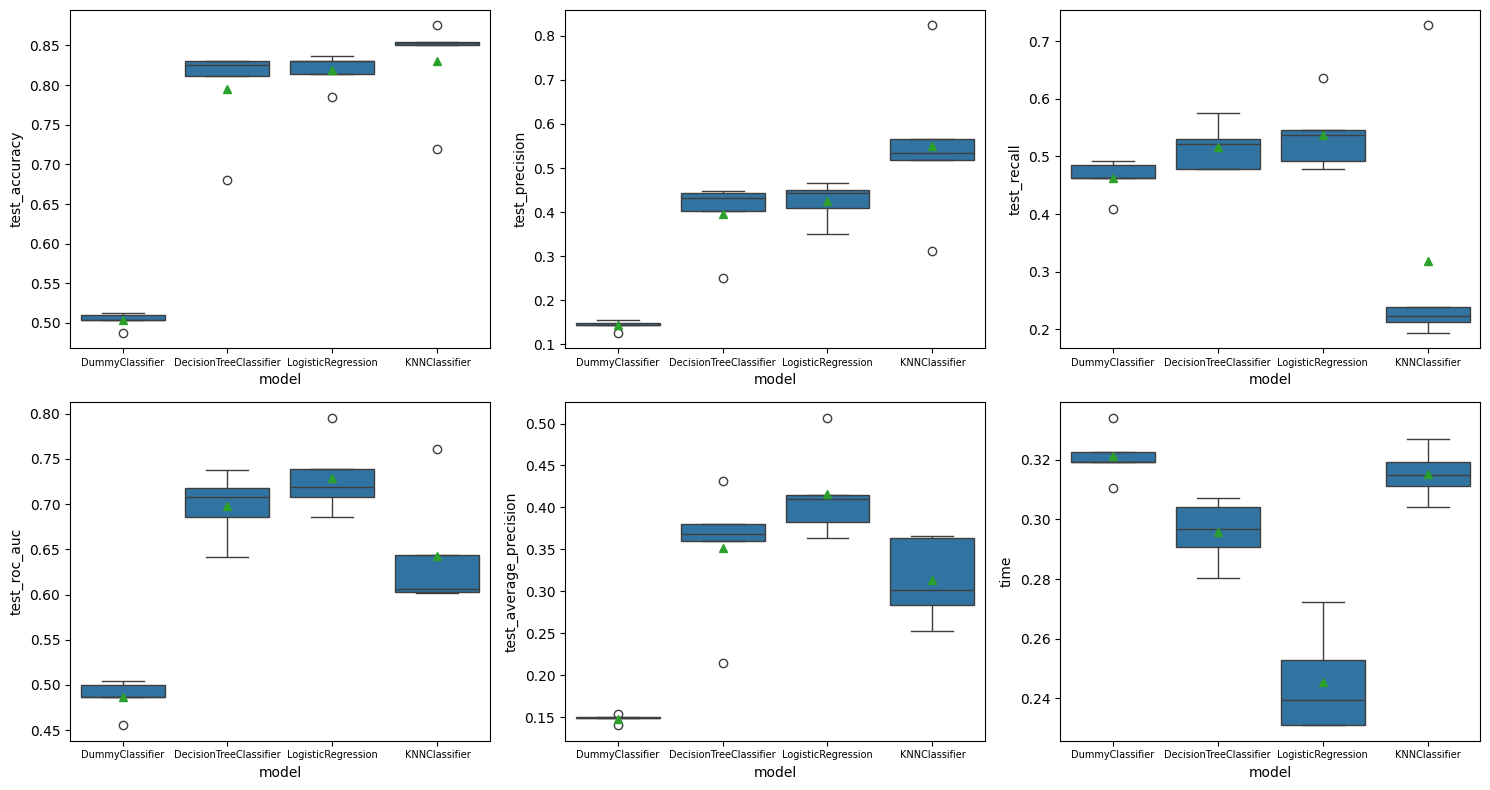

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), tight_layout=True)

cols = df_results.columns[3:].to_list()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(x="model", y=col, data=df_results_explode, ax=ax, showmeans=True)
    b.set_xticklabels(b.get_xticklabels(), fontsize=7)

plt.show()